In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# state = Connecticut
state_ab = "ct"

## Data
1. Download all the data in directory "tn_data"
2. Extract them all

In [6]:
data_folder = state_ab + "_data/"
population_data = "./{}{}_pl2020_b/{}_pl2020_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2022/Districts_1 2022-02-14.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_2021/{}_sldu_2021.shp".format(data_folder, state_ab, state_ab)
hdist_data = "./{}{}_sldl_2021/{}_sldl_2021.shp".format(data_folder, state_ab, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [7]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [8]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [9]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [10]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [11]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [12]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [13]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [14]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [19]:
population_df = gpd.read_file(population_data)
county_df = gpd.read_file(county_data)

In [20]:
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [21]:
maup.doctor(population_df)

100%|███████████████████████████████████| 49926/49926 [00:18<00:00, 2755.94it/s]


True

In [22]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [23]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [24]:
population_df.rename(columns=rename_dict, inplace = True)

Make sure that the County shapefile is clean:

In [25]:
maup.doctor(county_df)

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 431.29it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [26]:
vest20 = gpd.read_file(vest20_data)

In [27]:
vest20.columns

Index(['STATEFP20', 'COUNTYFP20', 'NAME20', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20PREGHAW', 'G20PREOWRI', 'geometry'],
      dtype='object')

In [28]:
start_col = 3
vest_base_data = vest20
year = '20'

In [29]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 474.10it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2214.38it/s]


Identifying overlaps...


100%|███████████████████████████████████████| 806/806 [00:00<00:00, 2577.40it/s]


Resolving overlaps and filling gaps...


Gaps to fill in region 0: 100%|███████████████████| 1/1 [00:00<00:00, 58.88it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 3: 100%|███████████████| 3/3 [00:00<00:00, 45.98it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 6: 100%|███████████████████| 2/2 [00:00<00:00, 63.53it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


In [30]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:1700])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [31]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 785/785 [00:00<00:00, 3276.06it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|███████████████████████████████████████| 741/741 [00:00<00:00, 1342.38it/s]


In [32]:
maup.doctor(vest_base)

100%|███████████████████████████████████████| 741/741 [00:00<00:00, 1334.51it/s]


True

## If it is true for maup doctor, we will use it as the base vest data.

In [33]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|████████████████████████████████████████| 741/741 [00:02<00:00, 253.73it/s]


In [34]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [35]:
election_df = gpd.GeoDataFrame(vest_base)

In [36]:
election_df.columns

Index(['COUNTYFP20', 'NAME20', 'PRE20D', 'PRE20O', 'PRE20R', 'STATEFP20',
       'geometry', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN',
       'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [37]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [38]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [39]:
vest18.columns

Index(['STATEFP20', 'COUNTYFP20', 'NAME20', 'G18USSDMUR', 'G18USSRCOR',
       'G18USSLLIO', 'G18USSGRUS', 'G18USSOWRI', 'G18GOVDLAM', 'G18GOVRSTE',
       'G18GOVLHAN', 'G18GOVOGRI', 'G18GOVOGRE', 'G18GOVOWRI', 'G18ATGDTON',
       'G18ATGRHAT', 'G18ATGGGOS', 'G18SOSDMER', 'G18SOSRCHA', 'G18SOSLGWY',
       'G18SOSGDER', 'G18TREDWOO', 'G18TRERGRA', 'G18TRELBRO', 'G18TREOWRI',
       'G18COMDLEM', 'G18COMRMIL', 'G18COMLPAS', 'G18COMGHEF', 'geometry'],
      dtype='object')

In [40]:
vest16.columns

Index(['STATEFP20', 'COUNTYFP20', 'NAME20', 'G16PREDCLI', 'G16PRERTRU',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSDBLU', 'G16USSRCAR',
       'G16USSLLIO', 'G16USSGRUS', 'G16USSOWRI', 'geometry'],
      dtype='object')

In [41]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|███████████████████████████████████████| 742/742 [00:00<00:00, 1253.48it/s]


There are 18 overlaps.
There are 1 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 806/806 [00:00<00:00, 4358.79it/s]

Resolving overlaps...


Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|████████████████████████████████████████| 741/741 [00:03<00:00, 244.60it/s]


population agrees


In [42]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18O', 'ATG18R', 'BVAP',
       'COM18D', 'COM18O', 'COM18R', 'COUNTYFP20', 'GOV18D', 'GOV18O',
       'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK',
       'H_NHPI', 'H_OTHER', 'H_WHITE', 'NAME20', 'NHPIVAP', 'NH_2MORE',
       'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE',
       'OTHERVAP', 'PRE20D', 'PRE20O', 'PRE20R', 'SOS18D', 'SOS18O', 'SOS18R',
       'STATEFP20', 'TOTPOP', 'TRE18D', 'TRE18O', 'TRE18R', 'USS18D', 'USS18O',
       'USS18R', 'VAP', 'WVAP', 'geometry'],
      dtype='object')

In [43]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|███████████████████████████████████████| 743/743 [00:00<00:00, 1328.13it/s]


There are 18 overlaps.
There are 2 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 807/807 [00:00<00:00, 4274.43it/s]

Resolving overlaps...


Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|████████████████████████████████████████| 741/741 [00:02<00:00, 254.44it/s]


population agrees


##  Add the district data

In [44]:
cd = gpd.read_file(cd_data)
cd = cd.to_crs(cd.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [45]:
cd.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,NH_WHT,DEVIATION,F_DEVIATIO,IDEAL_VALU,ALTERNATE_,POLSBY_POP,ALTERNATE1,POLSBY_PO1,PERIMETER,REOCK,F_NH_WHT,DISTRICT_L,geometry
0,1,526.080688,4,1.0,None,None,721189,410531,0.0,0.000000,721189.0,1.734680,0.332324,1.734680,0.332324,141.042622,0.321915,0.569242,4|0%,"POLYGON ((621788.544 4581420.639, 621798.749 4..."
1,2,501.357910,3,1.0,None,None,721189,437845,0.0,0.000000,721189.0,2.044058,0.239339,2.044058,0.239339,162.245252,0.363883,0.607115,3|0%,"POLYGON ((697915.027 4576186.947, 697930.902 4..."
2,3,1278.446280,5,1.0,None,None,721189,456795,0.0,0.000000,721189.0,2.084848,0.230065,2.084848,0.230065,264.253409,0.510607,0.633392,5|0%,"POLYGON ((666900.574 4599074.651, 666895.559 4..."
3,5,675.171570,1,1.0,None,None,721189,411361,0.0,0.000000,721189.0,2.435537,0.168582,2.435537,0.168582,224.339972,0.432572,0.570393,1|0%,"POLYGON ((654999.079 4656150.268, 655603.583 4..."
4,6,2133.337150,2,1.0,None,None,721188,562700,-1.0,-0.000001,721189.0,1.550315,0.416064,1.550315,0.416064,253.836811,0.572632,0.780240,2|-0%,"MULTIPOLYGON (((706123.050 4646704.990, 706103..."


In [46]:
election_df = add_district(send, "CD", election_df, "ID")

100%|██████████████████████████████████████████| 36/36 [00:00<00:00, 406.02it/s]


There are 3 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2732.81it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████████████████████████████████████| 36/36 [00:00<00:00, 386.28it/s]


In [47]:
send.head()

,ID,DISTRICT,DISTRICTN,geometry
0,1,1,1,"POLYGON ((693388.632 4616306.372, 693392.716 4..."
1,2,2,2,"POLYGON ((689920.080 4625707.034, 689918.374 4..."
2,3,3,3,"POLYGON ((694084.615 4626488.160, 694088.027 4..."
3,4,4,4,"POLYGON ((695613.244 4621713.998, 695650.498 4..."
4,5,5,5,"POLYGON ((681806.644 4617421.874, 681617.994 4..."


In [48]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|██████████████████████████████████████████| 36/36 [00:00<00:00, 416.01it/s]


There are 3 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 2763.23it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████████████████████████████████████| 36/36 [00:00<00:00, 354.01it/s]


In [49]:
hdist.head()

,ID,DISTRICT,DISTRICTN,geometry
0,1,1,1,"POLYGON ((689889.094 4625930.770, 689886.906 4..."
1,2,2,2,"POLYGON ((628031.869 4576122.821, 628009.497 4..."
2,3,3,3,"POLYGON ((689994.794 4623677.771, 689993.314 4..."
3,4,4,4,"POLYGON ((693309.430 4623292.017, 693293.454 4..."
4,5,5,5,"POLYGON ((694077.942 4626822.663, 694024.638 4..."


In [50]:

election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|████████████████████████████████████████| 151/151 [00:00<00:00, 768.35it/s]


There are 8 overlaps.
There are 147 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 156/156 [00:00<00:00, 3516.76it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|████████████████████████████████████████| 151/151 [00:00<00:00, 515.26it/s]


In [51]:
maup.doctor(election_df)

100%|███████████████████████████████████████| 741/741 [00:00<00:00, 1344.96it/s]


True

### Put the base precinct year after the precinct information column

In [52]:
# reorder the columns

fixed_columns = [
    'STATEFP20',
    'COUNTYFP20',
    'NAME20',
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [53]:
list(election_df.columns)

['STATEFP20',
 'COUNTYFP20',
 'NAME20',
 'CD',
 'SEND',
 'HDIST',
 'TOTPOP',
 'NH_2MORE',
 'NH_AMIN',
 'NH_ASIAN',
 'NH_BLACK',
 'NH_NHPI',
 'NH_OTHER',
 'NH_WHITE',
 'HISP',
 'H_AMIN',
 'H_ASIAN',
 'H_BLACK',
 'H_NHPI',
 'H_OTHER',
 'H_WHITE',
 'H_2MORE',
 'VAP',
 'HVAP',
 'WVAP',
 'BVAP',
 'AMINVAP',
 'ASIANVAP',
 'NHPIVAP',
 'OTHERVAP',
 '2MOREVAP',
 'ATG18D',
 'ATG18O',
 'ATG18R',
 'COM18D',
 'COM18O',
 'COM18R',
 'GOV18D',
 'GOV18O',
 'GOV18R',
 'PRE16D',
 'PRE16O',
 'PRE16R',
 'PRE20D',
 'PRE20O',
 'PRE20R',
 'SOS18D',
 'SOS18O',
 'SOS18R',
 'TRE18D',
 'TRE18O',
 'TRE18R',
 'USS16D',
 'USS16O',
 'USS16R',
 'USS18D',
 'USS18O',
 'USS18R',
 'geometry']

In [54]:
import os

# store the result in state directory
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

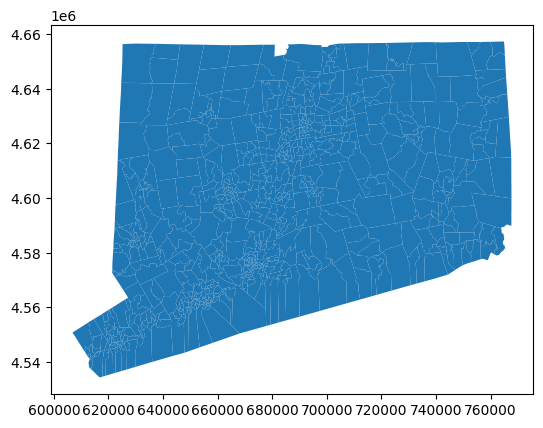

In [55]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()